In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import datetime

### Ok let's pick up where we left off with the Vela pulsar data

(This cell is just a repeat of loading the Vela data)

In [2]:
data = np.loadtxt(open("../data/Vela_Flux.txt", 'rb'), usecols=range(7))

# This is how we pull out the data from columns in the array.

# This is the date in "Mission Elapsed Time"
# For the Fermi mission, this is defined to be the number of seconds since the start of 2001.
date_MET = data[:,0]
# This is the offset in seconds between the Fermi "MET" and the UNIX "epoch" used by matplotlib
MET_To_Unix = 978336000

# These are the numbers of photons observed from Vela each week in the "low" Energy Band (100 MeV - 800 MeV)
nObs_LE = data[:,1]

# These are the number of photons expected from Vela each week, under the assumption that it is 
# not varying at all, and the only differences depend on how long we spent looking at Vela
# that particular weeek
nExp_LE = data[:,2]

# These are the band bounds, in MeV
LE_bounds = (100., 800.)

# This is the "significance" of the variation for each week.  We will discuss this more later
signif_LE = data[:,3]

nObs_HE = data[:,4]
nExp_HE = data[:,5]
signif_HE = data[:6]
HE_bounds = (800., 10000.)

# This converts the dates to something that matplotlib understands
dates = [datetime.datetime.fromtimestamp(date + MET_To_Unix) for date in date_MET]
date_YEAR = 2001 +  (date_MET / (24*3600*365))
years_since_mid_2014 = date_YEAR  - 2014.5

### Now let's add the functions we needed to minimize the $\chi^2$

That includes the model, a function to calculate the residuals and a function to compute the $\chi^2$


In [3]:
def linear_function(xvals, params):
    return params[0] + xvals*params[1]

def residual_function(data_x, data_y, model_function, params):
    model_y = model_function(data_x, params)
    residual = data_y - model_y
    return residual

def chi2_function(data_x, data_y, data_sigma_y, model_function, params):
    model_y = model_function(data_x, params)
    chi2 = ((data_y - model_y)/(data_sigma_y))**2
    return np.sum(chi2)

# Function minimizers

Finding the set of parameters that minimize a function is a very, very common thing the do in research.  In our case we are looking for the set of model parameters that give us the smallest $\chi^2$, i.e., the bit fit.

Since this is such a common thing to do, there are many software packages that will do it.  Typically they refer to the function that is being minimized as the "cost function", and they expect you to provide a function that takes only the model parameters as inputs.

So we are going to write a "cost function" that just calls our $\chi^2$ with the right versions of the data and model.  

Because the software we use (scipy.optimize) has a slightly different convention than what we are using, we will multiply the $\chi^2$ by a factor of 0.5 so that the uncertainty estimated returned by the minimizer will be correct.  

In [4]:
excess_counts = nObs_LE-nExp_LE
sigma_counts =  np.sqrt(nObs_LE)

def cost_function(params):
    return 0.5*chi2_function(years_since_mid_2014, excess_counts, sigma_counts, linear_function, params)

In [5]:
result = optimize.minimize(cost_function, [0., 0.])
pars = result['x']
fmin = result['fun']
p0_best = pars[0]
p1_best = pars[1]
cov = result['hess_inv']
p0_err = np.sqrt(cov[0,0])
p1_err = np.sqrt(cov[1,1])
correl = cov[1,0]/np.sqrt(p0_err*p1_err)

print("Fitter result:")
print(result)

print("")
print("Human readable version ---------------")
print("  Minimum value of cost function: %.1f" % fmin)
print("  Minimum value of chi**2: %.1f" % (2*fmin))
print("  p0 best fit: %.1f +- %.1f counts" % (p0_best, p1_err))
print("  p1 best fit: %.1f +- %.1f counts / year" % (p1_best, p1_err))
print("  Correlation between p0 and p1: %.2f" % correl)
print("  Number of times cost function was called to find minimum: %i" % result['nfev'])


Fitter result:
      fun: 382.2254022807482
 hess_inv: array([[ 4.36057701, -0.06324286],
       [-0.06324286,  0.33708028]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-1.71177646,  0.12882749])

Human readable version ---------------
  Minimum value of cost function: 382.2
  Minimum value of chi**2: 764.5
  p0 best fit: -1.7 +- 0.6 counts
  p1 best fit: 0.1 +- 0.6 counts / year
  Correlation between p0 and p1: -0.06
  Number of times cost function was called to find minimum: 18


### Ok, now let's draw the fit result on top of the contours we made 

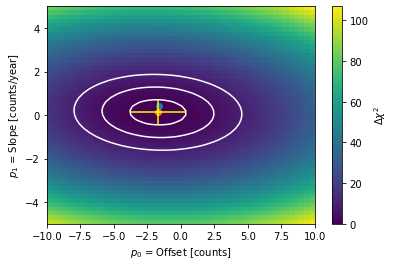

In [6]:
_ = plt.xlabel(r"$p_0$ = Offset [counts]")
_ = plt.ylabel(r"$p_1$ = Slope [counts/year]")


nx = 51
ny = 51

params = np.array([0., 0.])
chi2_2d_scan_vals = np.zeros((nx, ny))
offset_scan_points = np.linspace(-10., 10., nx)
slope_scan_points = np.linspace(-5., 5., ny)

# Double loop for 2d scan
for i in range(nx):
    params[0] = offset_scan_points[i]
    for j in range(ny):
        params[1] = slope_scan_points[j]
        chi2_2d_scan_vals[i,j] = chi2_function(years_since_mid_2014, excess_counts, sigma_counts,
                                               linear_function, params)

min_chi2 = chi2_2d_scan_vals.min()
chi2_2d_scan_vals -= min_chi2

# This next bit gets the x and y axis values for the grid point at the minimum.
idx = chi2_2d_scan_vals.argmin()
idx_x = idx//nx
idx_y = idx%ny
scan_min_x = offset_scan_points[idx_x]
scan_min_y = offset_scan_points[idx_y]

# Now let's plot it.
_ = plt.imshow(chi2_2d_scan_vals.T, extent=(-10, 10, -5, 5), aspect='auto', origin='lower')
_ = plt.colorbar(label=r"$\Delta \chi^2$")
_ = plt.contour(offset_scan_points, slope_scan_points, chi2_2d_scan_vals.T, levels=[1, 4, 9], colors="white")
_ = plt.scatter(scan_min_x, scan_min_y)
_ = plt.scatter(p0_best, p1_best)
_ = plt.errorbar(p0_best, p1_best, xerr=p0_err, yerr=p1_err, color='yellow')

# Correlation between model parameters.

Last week some of you commented that move the x-axis so that t=0 was in the middle of 2014 seemed a bit strange.

There was actually a very good reason to do that, which we will examine now.

So, Fermi actually launched in 2008.  So we could set t=0 to be in January 2008.

years_since_2008 = date_YEAR  - 2008.

In [7]:
excess_counts = nObs_LE-nExp_LE
_ = plt.scatter(years_since_2008, excess_counts)
_ = plt.xlabel(r"Date [years]")
_ = plt.ylabel(r"$n_{\rm ex}$ [per week]")

NameError: name 'years_since_2008' is not defined

Now, keep in mind that the model function we are using is a simple equation for a line. $y = p_0 + p_1 x$

By moving the zero point of the x-axis, we are changing a bit how that function works with the data.  To demonstrate we will make a plot for different values of $p_1$.

In [ ]:
_ = plt.xlabel(r"Time since 2008 [years]")
_ = plt.ylabel(r"$n_{\rm ex}$ [per week]")
_ = plt.errorbar(years_since_2008, excess_counts, yerr=sigma_counts, alpha=0.2)

xvals = years_since_2008
params = np.array([0., 0.])
for slope in np.linspace(-15, 15, 5):
    params[1] = slope
    _ = plt.plot(xvals, linear_function(xvals, params), label=r"Slope = %0.1f" % slope)
_ = plt.legend()

As you can see, all the lines cross at t=0, which is now off the left side of the plot.  Before it was more or less in the middle of the plot.  

What this means is that if you were to pick a value like, say, $p_1 = 7.5$ the model tend to be above average of the data for the entire time.  This means that you would have to change the offset $p_0$ to a negative number to compensate. 

That is exactly what we mean when we say that the parameters have become more correlated.  Let's explore this using the fitting.

In [ ]:
years_since_2008 = date_YEAR  - 2008.

def cost_function_bad(params):
    return 0.5*chi2_function(years_since_2008, excess_counts, sigma_counts, linear_function, params)



In [ ]:
result_bad = optimize.minimize(cost_function_bad, [0., 0.])
pars_bad = result_bad['x']
fmin_bad = result_bad['fun']
p0_best_bad = pars_bad[0]
p1_best_bad = pars_bad[1]
cov_bad = result_bad['hess_inv']
p0_err_bad = np.sqrt(cov_bad[0,0])
p1_err_bad = np.sqrt(cov_bad[1,1])
correl_bad = cov_bad[1,0]/(p0_err_bad*p1_err_bad)

print("")
print("Human readable version: bad idea ---------------")
print("  Minimum value of cost function: %.1f" % fmin_bad)
print("  Minimum value of chi**2: %.1f" % (2*fmin_bad))
print("  p0 best fit: %.1f +- %.1f counts" % (p0_best_bad, p0_err_bad))
print("  p1 best fit: %.1f +- %.1f counts / year" % (p1_best_bad, p1_err_bad))
print("  Correlation between p0 and p1: %.2f" % correl_bad)

In [ ]:
_ = plt.xlabel(r"$p_0$ = Offset [counts]")
_ = plt.ylabel(r"$p_1$ = Slope [counts/year]")

chi2_2d_scan_vals_bad = np.zeros((nx, ny))
offset_scan_points = np.linspace(-10., 10., nx)
slope_scan_points = np.linspace(-5., 5., ny)

# Double loop for 2d scan
for i in range(nx):
    params[0] = offset_scan_points[i]
    for j in range(ny):
        params[1] = slope_scan_points[j]
        chi2_2d_scan_vals_bad[i,j] = chi2_function(years_since_2008, excess_counts, sigma_counts,
                                                   linear_function, params)

min_chi2_bad = chi2_2d_scan_vals_bad.min()
chi2_2d_scan_vals_bad -= min_chi2_bad

# Now let's plot it.
_ = plt.imshow(chi2_2d_scan_vals_bad.T, extent=(-10, 10, -5, 5), aspect='auto', origin='lower')
_ = plt.colorbar(label=r"$\Delta \chi^2$")
_ = plt.contour(offset_scan_points, slope_scan_points, chi2_2d_scan_vals_bad.T, levels=[1, 4, 9], colors="white")
_ = plt.errorbar(p0_best_bad, p1_best_bad, xerr=p0_err_bad, yerr=p1_err_bad, color='cyan')
#_ = plt.errorbar(p0_best, p1_best, xerr=p0_err, yerr=p1_err, color='yellow')

print("Best fit value is %0.1f for (%0.1f +- %0.1f, %0.1f +- %0.1f)" % 
          (min_chi2_bad, p0_best_bad, p0_err_bad, p1_best_bad, p1_err_bad))

print("Best fit value is %0.1f for (%0.1f +- %0.1f, %0.1f +- %0.1f)" % 
          (min_chi2, p0_best, p0_err, p1_best, p1_err))

print("Original correlation was %.2f, now it is %.2f" % (correl, correl_bad))